In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Carga y preparacion de datos

In [2]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [3]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [4]:
nombres=df.drop(['CompTotal'], axis=1).columns

In [5]:
df.isnull().values.any()

False

Para comprender mejor la distribución de la variable objetivo 'target' (salario), se ha generado un gráfico de densidad utilizando la función `kdeplot` de la biblioteca `seaborn`. 

El gráfico resultante muestra una *distribución asimétrica positiva*, con una mayor concentración de salarios entre 0 y 100.000 y una cola que se extiende hacia valores más altos, llegando hasta aproximadamente 400.000.

Esta visualización permite extraer las siguientes conclusiones:

- **Asimetría positiva**: La distribución presenta un sesgo hacia la derecha, lo que indica que la mayoría de los salarios son relativamente bajos, mientras que hay una menor proporción de salarios altos.
- **Valores extremos**: La cola derecha extendida sugiere la presencia de valores atípicamente altos que podrían influir en el modelo. Se considerarán estos valores como outliers y se aplicarán técnicas estadísticas para su tratamiento.
- **Concentración de datos**: La mayor densidad se observa en el rango de 0 a 100.000, lo que indica el rango de salarios más común.
- **Valores cercanos a cero**: Se observa una pequeña concentración de valores alrededor de cero, lo que requiere una investigación más profunda para determinar su naturaleza.

Estas observaciones sugieren que podría ser beneficioso aplicar transformaciones a la variable 'target' para reducir la asimetría y mejorar el rendimiento del modelo. Además, se investigará la naturaleza de los valores cercanos a cero y se aplicarán técnicas de detección y tratamiento de outliers a los valores extremos.

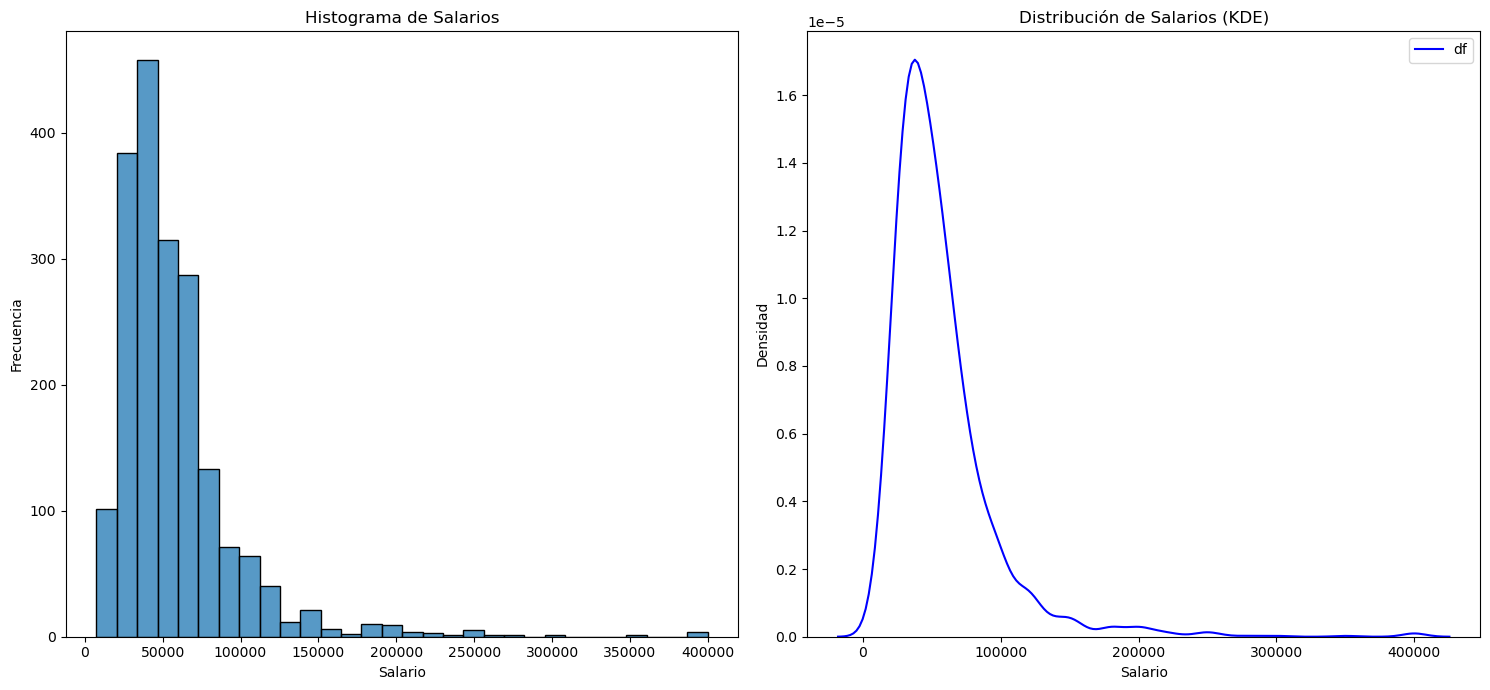

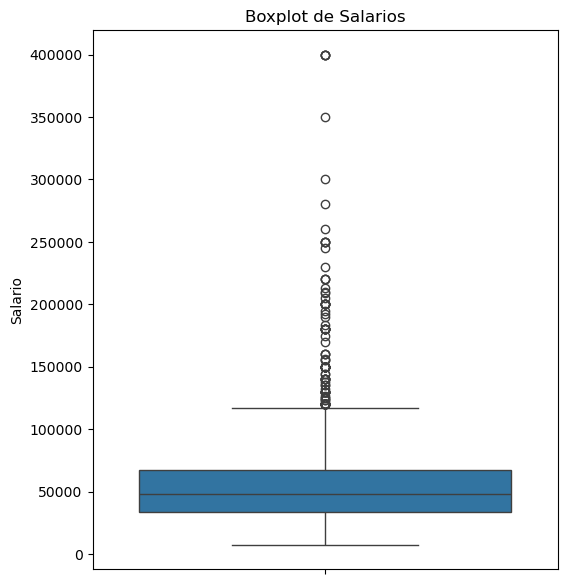

In [6]:
# 1. Histograma y gráfico de densidad
plt.figure(figsize=(15, 7))

# Histograma
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.histplot(df['CompTotal'], kde=False, bins=30)
plt.title('Histograma de Salarios')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')

# KDE Plot
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.kdeplot(df['CompTotal'], label='df', color='blue')
plt.title('Distribución de Salarios (KDE)')
plt.xlabel('Salario')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Boxplot
plt.figure(figsize=(6, 7))
sns.boxplot(y=df['CompTotal'])
plt.title('Boxplot de Salarios')
plt.ylabel('Salario')
plt.show()

In [7]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

**Conclusión:**
- Tanto el histograma como el KDE plot nos permiten ver que hay una distribución asimetrica positiva, con la mayor parte de los datos concentrados entre 20000 y 80000, y con una cola hacia la derecha.
- El boxplot muestra que hay algunos valores por encima del bigote superior, que podrían considerarse como outliers, como la regla del 1.5xIQR.
___________________________________________________________________________________________________________________

**Filtro y umbrales:**

Para identificar y tratar los valores atípicos en la variable 'target' (salario), se han utilizado las siguientes técnicas:

1) Visualización:
- Se ha generado un histograma y un gráfico de densidad para visualizar la distribución de los salarios.
- Se ha generado un boxplot para identificar visualmente los outliers.
2) Rango Intercuartílico (IQR):
Se ha calculado el IQR y se han considerado outliers los valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR], que corresponde a [-16993.75, 117396.25].
3) Percentiles:
Se han utilizado los percentiles 3 y 95 para definir los límites inferior y superior, respectivamente. Los valores fuera del rango [18000.0, 120000.0] se han considerado outliers. 

In [8]:
# 3. IQR
Q1 = df['CompTotal'].quantile(0.25)
Q3 = df['CompTotal'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior_iqr = Q1 - 1.5 * IQR
limite_superior_iqr = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Límite inferior (IQR): {limite_inferior_iqr}")
print(f"Límite superior (IQR): {limite_superior_iqr}")

# 4. Percentiles
percentil_3 = df['CompTotal'].quantile(0.03)
percentil_95 = df['CompTotal'].quantile(0.95)

print(f"Percentil 3: {percentil_3}")
print(f"Percentil 95: {percentil_95}")

# Del boxplot y el IQR, ya podemos identificar algunos outliers.
# Usemos ahora los límites calculados para filtrar el DataFrame

# Filtrar outliers usando IQR
df_filtrado_iqr = df[(df['CompTotal'] >= limite_inferior_iqr) & (df['CompTotal'] <= limite_superior_iqr)]

# Filtrar outliers usando percentiles
df_filtrado_percentiles = df[(df['CompTotal'] >= percentil_3) & (df['CompTotal'] <= percentil_95)]

# Comparar tamaños de los DataFrames
print(f"\nTamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado con IQR: {df_filtrado_iqr.shape}")
print(f"Tamaño del DataFrame filtrado con percentiles: {df_filtrado_percentiles.shape}")

IQR: 33597.5
Límite inferior (IQR): -16993.75
Límite superior (IQR): 117396.25
Percentil 3: 18000.0
Percentil 95: 120000.0

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado con IQR: (1817, 397)
Tamaño del DataFrame filtrado con percentiles: (1801, 397)


**Interpretación y comparación:**

- IQR: Sugiere un límite superior de 117396.25 euros.
- Percentiles: Sugiere el límine superior en 120000 euros (con el percentil 95).

- Elección del límite inferior:
    - El percentil 3 (18000) es concordante con los límites mínimo establecido en el convenio colectivo del sector (17.599,36 para la categoría mínima), por lo que usaré ese mínimo. 
- Elección del límite superior:
    - El IQR da un límite inferior similar (-16993.75) que el percentil 3, aunque por las razones expuestas se utilizará el límite establecido en Conveio colectivo. 
    - Teniendo en cuenta el análisis visual del gráfico de densidad, éste sugiere que la "cola" empieza alrededor de 150,000.
    - Usar 120000 euros como límite superior parece un valor razonable que permite eliminar una buena parte de los outliers, eliminando tan solo el 5% de los datos.

Como resultado del análisis, y como se puede ver en los gráficos, se ha decidido utilizar el método percentil para la eliminación de outliers, ya que proporciona un equilibrio entre la eliminación de valores extremos y la conservación de datos (se eliminan 132 datos, lo que representa un 6.83% de los datos).

La decisión de utilizar este método y este porcentaje de eliminación se basa en la observación de que los valores eliminados se encuentran en las colas de la distribución y su inclusión podría afectar negativamente el rendimiento del modelo.

In [9]:
limite_inferior = 17599.36
limite_superior = 120000

df_filtrado = df[(df['CompTotal'] >= limite_inferior) & (df['CompTotal'] <= limite_superior)]

print(f"Tamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado: {df_filtrado.shape}")

df = df_filtrado

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado: (1802, 397)


In [10]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

In [11]:
df

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

**Problema en la Distribución Original:** 

La distribución original de la variable CompTotal presentaba un marcado sesgo positivo (sesgo a la derecha). Esto significa que había una mayor concentración de valores en el extremo inferior del rango salarial, con una cola larga extendiéndose hacia valores más altos. Además, se insinuaba una posible multimodalidad, sugiriendo la presencia de múltiples grupos con diferentes rangos salariales dentro de la distribución. Este tipo de distribución puede ser problemático para muchos algoritmos de machine learning que asumen normalidad o simetría en los datos, pudiendo afectar negativamente al rendimiento del modelo.

*Transformación Aplicada:*

Para abordar los problemas de sesgo y no normalidad, se aplicó una transformación logarítmica a la variable CompTotal. Específicamente, se utilizó la función log1p, que calcula el logaritmo natural de (1 + x), lo cual es útil para manejar valores que pueden ser cero.

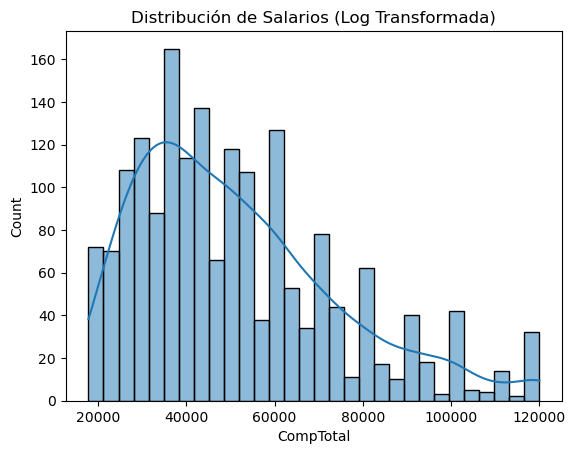

In [12]:
# Target sin transformacion:
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

## RECORDAR REVERTIR EL LOGARITMO DESPUES!!!!!!!!!

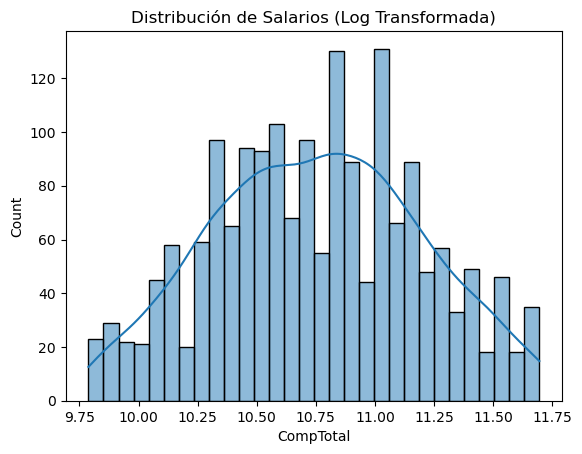

In [13]:
# Target con transformacion logaritmica
df['CompTotal'] = np.log1p(df['CompTotal'])
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

*Conclusiones:*

La transformación logarítmica ha sido muy efectiva para normalizar la distribución de la variable CompTotal. La distribución transformada es más simétrica, se aproxima más a una distribución normal y es más adecuada para su uso en modelos de machine learning que asumen estas características en los datos. La reducción del sesgo y la mitigación de la multimodalidad son indicadores claros del éxito de la transformación.
________________________________________________________________________________________________

Ya esta todo listo para dividir mis conjuntos de train y test.

In [14]:
y = df['CompTotal']

In [15]:
df = df.drop(columns=['CompTotal'], axis=1)

In [16]:
columnas = df.columns

In [17]:
# --- 1. Dividir los Datos en Entrenamiento, Validación y Prueba ---
X_temp, X_test, y_temp, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1080, 396)
(361, 396)
(361, 396)
(1080,)
(361,)
(361,)


Escalo los datos 

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
print("X_train - Máximo:", X_train.max())
print("X_train - Mínimo:", X_train.min())
print("X_val - Máximo:", X_val.max())
print("X_val - Mínimo:", X_val.min())

X_train - Máximo: 1.0
X_train - Mínimo: 0.0
X_val - Máximo: 1.32
X_val - Mínimo: -0.002331932773109238


# Modelos

Random Forest con hiperparametros por defecto

In [22]:
# Crear un modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)
# Entrenar el modelo
rf_model.fit(X_train, y_train)

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = rf_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = rf_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)
# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 35312616.537
RMSE: 5942.44
MAE: 3844.410
R2: 0.930
MAPE: 7.27

--- VALIDATION ---
MSE: 248488594.850
RMSE: 15763.52
MAE: 10812.689
R2: 0.580
MAPE: 22.56


El modelo parece estar overfitteado. Pruebo con regularización y búsqueda de mejores hiperparámetros con Gridsearch.

In [23]:
# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir el espacio de hiperparámetros
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 3]
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # Número de folds para la validación cruzada
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Ajustar el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Imprimir los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_rf_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_rf_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_const

Mejores parámetros: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

--- TRAIN ---
MSE: 122899657.069
RMSE: 11086.01
MAE: 7577.170
R2: 0.758
MAPE: 14.49

--- VALIDATION ---
MSE: 260425197.479
RMSE: 16137.69
MAE: 10941.115
R2: 0.560
MAPE: 22.72


In [25]:
# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir el espacio de hiperparámetros
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # Número de folds para la validación cruzada
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2
)

# Ajustar el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [27]:
# Obtener las características más importantes
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 300 características más importantes
top_features = indices[:100]
X_train_reduced = X_train[:, top_features]
X_val_reduced = X_val[:, top_features]
X_test_reduced = X_test[:, top_features]

# Reajustar el modelo con las 100 mejores características
best_rf_model.fit(X_train_reduced, y_train)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_rf_model.predict(X_train_reduced)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_rf_model.predict(X_val_reduced)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")


--- TRAIN ---
MSE: 131316013.640
RMSE: 11459.32
MAE: 7726.191
R2: 0.741
MAPE: 14.97

--- VALIDATION ---
MSE: 259372176.657
RMSE: 16105.04
MAE: 11032.875
R2: 0.562
MAPE: 22.83


In [30]:
# Obtener las características más importantes
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 300 características más importantes
top_features = indices[:100]
X_train_reduced = X_train[:, top_features]
X_val_reduced = X_val[:, top_features]
X_test_reduced = X_test[:, top_features]

# Reajustar el modelo con las 100 mejores características
best_rf_model.fit(X_train_reduced, y_train)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_rf_model.predict(X_train_reduced)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_rf_model.predict(X_val_reduced)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")


--- TRAIN ---
MSE: 147097183.330
RMSE: 12128.36
MAE: 8182.923
R2: 0.710
MAPE: 15.99

--- VALIDATION ---
MSE: 264148444.972
RMSE: 16252.64
MAE: 11214.259
R2: 0.554
MAPE: 23.39


______________________________________________________________________________________
Seguiré probadno con otros modelos, y en su caso volveré a buscar mejores hiperparámetros para el Random Forest.
______________________________________________________________________________________

GradientBoostingRegressor con hiperparametros por defecto.

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
# Crear un modelo de GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gbr_model.fit(X_train, y_train)

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = gbr_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = gbr_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 98116138.980
RMSE: 9905.36
MAE: 7157.183
R2: 0.807
MAPE: 14.11

--- VALIDATION ---
MSE: 230022036.096
RMSE: 15166.48
MAE: 10495.096
R2: 0.612
MAPE: 21.61


GradientBoostingRegressor, buscando con RandomizedSearchCV los mejores hiperparametros

In [32]:
# --- Definir el Espacio de Búsqueda de Hiperparámetros ---
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2'],
    'alpha': [0.1, 0.5, 0.9], #parametro de regularizacion L1
    'ccp_alpha': [0.0, 0.01, 0.1] #parametro para la poda
}

# --- Instanciar el Modelo y RandomizedSearchCV ---
gbr = GradientBoostingRegressor(random_state=42, loss='squared_error')  # Usar GradientBoostingRegressor
random_search = RandomizedSearchCV(
    estimator=gbr,  # Cambiar a GradientBoostingRegressor
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinaciones a probar
    cv=3,  # Número de folds en la validación cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Usar todos los procesadores disponibles
    scoring='neg_mean_squared_error'  # Puedes usar otra métrica si lo prefieres
)

# --- Ajustar RandomizedSearchCV a los Datos ---
random_search.fit(X_train, y_train)

# --- Obtener los Mejores Hiperparámetros y el Mejor Modelo ---
best_params = random_search.best_params_
best_gbr = random_search.best_estimator_

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = best_gbr.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = best_gbr.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constr

--- TRAIN ---
MSE: 7775179.097
RMSE: 2788.40
MAE: 1815.493
R2: 0.985
MAPE: 3.53

--- VALIDATION ---
MSE: 227074942.772
RMSE: 15069.01
MAE: 10762.198
R2: 0.617
MAPE: 21.98


In [33]:
# Obtener las características más importantes
importances = best_gbr.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 300 características más importantes
top_features = indices[:100]
X_train_reduced = X_train[:, top_features]
X_val_reduced = X_val[:, top_features]
X_test_reduced = X_test[:, top_features]

# Reajustar el modelo con las 100 mejores características
best_gbr.fit(X_train_reduced, y_train)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_gbr.predict(X_train_reduced)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_gbr.predict(X_val_reduced)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")


--- TRAIN ---
MSE: 3401206.005
RMSE: 1844.24
MAE: 1168.172
R2: 0.993
MAPE: 2.27

--- VALIDATION ---
MSE: 205359835.086
RMSE: 14330.38
MAE: 10215.340
R2: 0.653
MAPE: 21.11


SVR con hiperparametros por defecto

In [36]:
# Crear un modelo de GradientBoostingRegressor
svr = SVR()

# Entrenar el modelo
svr.fit(X_train, y_train)

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = svr.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = svr.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 49174122.729
RMSE: 7012.43
MAE: 5190.304
R2: 0.903
MAPE: 10.16

--- VALIDATION ---
MSE: 323030397.183
RMSE: 17973.05
MAE: 12960.129
R2: 0.455
MAPE: 25.70


SVR buscando con RandomizedSearch los mejores hiperparametros

Pruebo lo mismo pero con Randomized Search en vez de Grid

In [38]:
# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'C': np.logspace(-2, 3, 6),  # Rango más amplio para C
    'gamma': np.logspace(-4, 1, 6),  # Rango más amplio para gamma
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4] # Grado del kernel polinómico
}

# Instanciar el modelo y RandomizedSearchCV
svr = SVR()
random_search = GridSearchCV(estimator=svr, param_grid=param_distributions,
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar GridSearchCV a los datos
random_search.fit(X_train, y_train)

# --- Obtener los Mejores Hiperparámetros y el Mejor Modelo ---
best_params = random_search.best_params_
best_svr = random_search.best_estimator_

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = best_svr.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = best_svr.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 123641994.654
RMSE: 11119.44
MAE: 7523.777
R2: 0.756
MAPE: 14.83

--- VALIDATION ---
MSE: 317527018.333
RMSE: 17819.29
MAE: 12887.179
R2: 0.464
MAPE: 25.48


Gradient Boosting Machine con hiperparametros por defecto

In [27]:
# # Instanciar el modelo
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Entrenar el modelo
# xgb_reg.fit(X_train, y_train)

# # --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# # Entrenamiento
# y_train_pred_log = xgb_reg.predict(X_train)
# y_train_pred = np.expm1(y_train_pred_log)
# y_train_original = np.expm1(y_train)

# # Validación
# y_val_pred_log = xgb_reg.predict(X_val)
# y_val_pred = np.expm1(y_val_pred_log)
# y_val_original = np.expm1(y_val)

# # --- 4. Calcular Métricas en la Escala Original ---
# # Entrenamiento
# mse_train = mean_squared_error(y_train_original, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# mae_train = mean_absolute_error(y_train_original, y_train_pred)
# r2_train = r2_score(y_train_original, y_train_pred)
# mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# # Validación
# mse_val = mean_squared_error(y_val_original, y_val_pred)
# rmse_val = np.sqrt(mse_val)
# mae_val = mean_absolute_error(y_val_original, y_val_pred)
# r2_val = r2_score(y_val_original, y_val_pred)
# mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# # --- 5. Imprimir Resultados ---
# print("--- TRAIN ---")
# print(f"MSE: {mse_train:.3f}")
# print(f"RMSE: {rmse_train:.2f}")
# print(f"MAE: {mae_train:.3f}")
# print(f"R2: {r2_train:.3f}")
# print(f"MAPE: {mape_train:.2f}")

# print("\n--- VALIDATION ---")
# print(f"MSE: {mse_val:.3f}")
# print(f"RMSE: {rmse_val:.2f}")
# print(f"MAE: {mae_val:.3f}")
# print(f"R2: {r2_val:.3f}")
# print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 991963.718
RMSE: 995.97
MAE: 602.554
R2: 0.998
MAPE: 1.18

--- VALIDATION ---
MSE: 235367371.884
RMSE: 15341.69
MAE: 11256.799
R2: 0.603
MAPE: 23.67


In [40]:
# Definir el modelo base
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 5 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Entrenar el modelo final con los mejores parámetros
best_xgb_reg = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_xgb_reg.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_xgb_reg.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores parámetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Mejor puntaje (MAE): 0.1998810446664716
--- TRAIN ---
MSE: 109270779.105
RMSE: 10453.27
MAE: 7145.511
R2: 0.785
MAPE: 13.77

--- VALIDATION ---
MSE: 241725184.036
RMSE: 15547.51
MAE: 10857.073
R2: 0.592
MAPE: 22.22


In [41]:
# --- Importancia de las Características (si es necesario) ---
feature_importances = best_xgb_reg.feature_importances_

# Paso 1: Obtener importancias de las características y nombres
feature_names = columnas
# Convertir las matrices NumPy a DataFrames de pandas
X_train_df = pd.DataFrame(X_val, columns=feature_names)

# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
importance_df.head(50)

,Feature,Importance
3,YearsCodePro,0.039155
24,LearnCodeOnline_encoded,0.025027
377,OfficeStackSyncHaveWorkedWith_Slack,0.014968
178,PlatformHaveWorkedWith_Amazon Web Services (AWS),0.009989
95,LanguageHaveWorkedWith_VBA,0.008881
17,is_independent,0.008662
81,LanguageHaveWorkedWith_Objective-C,0.008653
310,NEWCollabToolsHaveWorkedWith_Eclipse,0.008559
33,MacOS,0.008548
124,LanguageWantToWorkWith_Lua,0.008298


Entrenar el modelo solo con el top 50 features

In [42]:
# Paso 1: Seleccionar las 50 características más importantes
top_features = importance_df['Feature'].head(50).tolist()

# Convertir X_train y X_val a DataFrames (si no lo están ya)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# Filtrar los conjuntos de entrenamiento y validación
X_train_filtered = X_train_df[top_features]
X_val_filtered = X_val_df[top_features]

# Paso 2: Definir el modelo base
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Paso 3: Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],  # Regularización L2
    'reg_alpha': [0.1, 1, 10],   # Regularización L1
    'min_child_weight': [3, 5, 7]
}

# Paso 4: Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 3 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Paso 5: Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_filtered, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Paso 6: Entrenar el modelo final con los mejores parámetros
best_xgb_reg = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_xgb_reg.predict(X_train_filtered)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_xgb_reg.predict(X_val_filtered)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 4374 candidates, totalling 13122 fits
Mejores parámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Mejor puntaje (MAE): 0.18987392491652835
--- TRAIN ---
MSE: 88661524.831
RMSE: 9416.02
MAE: 6599.583
R2: 0.825
MAPE: 12.93

--- VALIDATION ---
MSE: 222350806.287
RMSE: 14911.43
MAE: 10534.961
R2: 0.625
MAPE: 21.61


# Probar en xgboost:
Reduce max_depth: Prueba con valores más bajos (por ejemplo, 3, 4, 5).
Aumenta min_child_weight: Prueba con valores más altos (por ejemplo, 3, 5, 7).
Ajusta subsample y colsample_bytree: Prueba con valores entre 0.6 y 0.9.
Introduce lambda (L2) y alpha (L1): Empieza con valores pequeños (por ejemplo, 0.01, 0.1, 1) y aumenta gradualmente.
learning_rate: Prueba con un valor más bajo (por ejemplo, 0.01 o 0.05) y aumenta n_estimators si es necesario.


anterior: Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores parámetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
Mejor puntaje (MAE): 0.19423797306936907
--- TRAIN ---
MSE: 10687492.052
RMSE: 3269.17
MAE: 2186.263
R2: 0.979
MAPE: 4.33

--- VALIDATION ---
MSE: 211461654.351
RMSE: 14541.72
MAE: 10624.108
R2: 0.643
MAPE: 22.02

In [43]:
# Definir el modelo base
elastic_net = ElasticNet(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'max_iter': [1000, 5000],
    'tol': [1e-4, 1e-5]
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 3 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Entrenar el modelo final con los mejores parámetros
best_elastic_net = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_elastic_net.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_elastic_net.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros encontrados: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'tol': 1e-05}
Mejor puntaje (MAE): 0.2841537057828651
--- TRAIN ---
MSE: 359411322.600
RMSE: 18958.15
MAE: 14030.267
R2: 0.291
MAPE: 28.96

--- VALIDATION ---
MSE: 436991383.624
RMSE: 20904.34
MAE: 15250.629
R2: 0.262
MAPE: 30.31


In [44]:
# Extraer los coeficientes del modelo
feature_importances_en = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_elastic_net.coef_
}).sort_values(by='Importance', key=abs, ascending=False)

In [45]:
# Paso 1: Seleccionar las 50 características más importantes
top_features = feature_importances_en['Feature'].head(50).tolist()

# Convertir X_train y X_val a DataFrames (si no lo están ya)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# Filtrar los conjuntos de entrenamiento y validación
X_train_filtered = X_train_df[top_features]
X_val_filtered = X_val_df[top_features]

# Definir el modelo base
elastic_net = ElasticNet(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],
    'max_iter': [1000, 5000],
    'tol': [1e-4, 1e-5]
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 3 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train_filtered, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Entrenar el modelo final con los mejores parámetros
best_elastic_net = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_elastic_net.predict(X_train_filtered)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_elastic_net.predict(X_val_filtered)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros encontrados: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'tol': 1e-05}
Mejor puntaje (MAE): 0.2836562994023342
--- TRAIN ---
MSE: 359411386.888
RMSE: 18958.15
MAE: 14030.269
R2: 0.291
MAPE: 28.96

--- VALIDATION ---
MSE: 436991491.646
RMSE: 20904.34
MAE: 15250.631
R2: 0.262
MAPE: 30.31


In [46]:
cat = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=100)
cat.fit(X_train, y_train)

# Hacer predicciones
y_train_pred_log = cat.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = cat.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

0:	learn: 0.4170711	total: 157ms	remaining: 2m 37s
100:	learn: 0.1871874	total: 1.46s	remaining: 13s
200:	learn: 0.1383650	total: 2.53s	remaining: 10.1s
300:	learn: 0.1014594	total: 3.61s	remaining: 8.38s
400:	learn: 0.0777504	total: 4.72s	remaining: 7.06s
500:	learn: 0.0610950	total: 5.78s	remaining: 5.75s
600:	learn: 0.0472066	total: 6.76s	remaining: 4.49s
700:	learn: 0.0364557	total: 7.79s	remaining: 3.32s
800:	learn: 0.0294089	total: 8.81s	remaining: 2.19s
900:	learn: 0.0238090	total: 9.89s	remaining: 1.09s
999:	learn: 0.0194559	total: 10.9s	remaining: 0us
--- TRAIN ---
MSE: 1233706.011
RMSE: 1110.72
MAE: 741.275
R2: 0.998
MAPE: 1.44

--- VALIDATION ---
MSE: 198250538.079
RMSE: 14080.15
MAE: 9943.032
R2: 0.665
MAPE: 20.43


In [47]:
# # Crear el modelo LightGBM
# lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression')

# # Definir un espacio de búsqueda más amplio
# param_distributions = {
#     'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2],
#     'n_estimators': [50, 70, 100, 120],
#     'max_depth': [2, 3, 4, 5, -1],
#     'num_leaves': [15, 31, 63, 127, 255],
#     'colsample_bytree': [0.6, 0.7, 0.8],
#     'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'min_child_samples': [1, 2, 5, 10, 15, 20],
#     'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2],
#     'reg_lambda': [0, 0.01, 0.1, 0.5, 1, 2]
# }

# # Crear el objeto RandomizedSearchCV
# random_search_lgb = RandomizedSearchCV(estimator=lgb_model,
#                                    param_distributions=param_distributions,
#                                    n_iter=200,  # Aumentar el número de iteraciones
#                                    scoring='neg_mean_squared_error',
#                                    cv=5,
#                                    n_jobs=-1,
#                                    verbose=2,
#                                    random_state=42)

# # Ajustar RandomizedSearchCV a los datos de entrenamiento
# random_search_lgb.fit(X_train, y_train)

# # Hacer predicciones
# y_train_pred_log = random_search_lgb.predict(X_train)
# y_train_pred = np.expm1(y_train_pred_log)
# y_train_original = np.expm1(y_train)

# y_val_pred_log = random_search_lgb.predict(X_val)
# y_val_pred = np.expm1(y_val_pred_log)
# y_val_original = np.expm1(y_val)

# # Calcular métricas
# mse_train = mean_squared_error(y_train_original, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# mae_train = mean_absolute_error(y_train_original, y_train_pred)
# r2_train = r2_score(y_train_original, y_train_pred)
# mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# mse_val = mean_squared_error(y_val_original, y_val_pred)
# rmse_val = np.sqrt(mse_val)
# mae_val = mean_absolute_error(y_val_original, y_val_pred)
# r2_val = r2_score(y_val_original, y_val_pred)
# mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# print("--- TRAIN ---")
# print(f"MSE: {mse_train:.3f}")
# print(f"RMSE: {rmse_train:.2f}")
# print(f"MAE: {mae_train:.3f}")
# print(f"R2: {r2_train:.3f}")
# print(f"MAPE: {mape_train:.2f}")

# print("\n--- VALIDATION ---")
# print(f"MSE: {mse_val:.3f}")
# print(f"RMSE: {rmse_val:.2f}")
# print(f"MAE: {mae_val:.3f}")
# print(f"R2: {r2_val:.3f}")
# print(f"MAPE: {mape_val:.2f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

- Ensemble de modelos: Combina los mejores modelos que has entrenado hasta ahora (XGBoost, Random Forest, Gradient Boosting) en un ensemble. Puedes usar VotingRegressor o StackingRegressor de scikit-learn.

In [52]:
# Definir tus mejores modelos
cat = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=100)
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 5, min_child_weight= 5, n_estimators= 100, reg_alpha= 0.1, reg_lambda= 0.1, subsample= 0.8)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, loss='squared_error')

# Crear el ensemble
voting_regressor = VotingRegressor(estimators=[('cat', cat), ('xgb', xgb_reg), ('gb', gb_model)])

# Ajustar el ensemble al conjunto de entrenamiento
voting_regressor.fit(X_train, y_train)

# Hacer predicciones
y_train_pred_log = voting_regressor.predict(X_train)
y_val_pred_log = voting_regressor.predict(X_val)

# Aplicar transformación inversa
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)

# Obtener los valores originales
y_train_original = np.expm1(y_train)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100


# Imprimir resultados
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.3f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.3f}")

0:	learn: 0.4170711	total: 8.23ms	remaining: 8.22s
100:	learn: 0.1871874	total: 1.49s	remaining: 13.3s
200:	learn: 0.1383650	total: 2.98s	remaining: 11.8s
300:	learn: 0.1014594	total: 4.52s	remaining: 10.5s
400:	learn: 0.0777504	total: 6.06s	remaining: 9.06s
500:	learn: 0.0610950	total: 7.48s	remaining: 7.45s
600:	learn: 0.0472066	total: 8.8s	remaining: 5.84s
700:	learn: 0.0364557	total: 10.1s	remaining: 4.31s
800:	learn: 0.0294089	total: 11.2s	remaining: 2.78s
900:	learn: 0.0238090	total: 12.3s	remaining: 1.35s
999:	learn: 0.0194559	total: 13.7s	remaining: 0us
--- TRAIN ---
MSE: 42600268.759
RMSE: 6526.89
MAE: 4554.95
R2: 0.916
MAPE: 8.788

--- VALIDATION ---
MSE: 202757335.307
RMSE: 14239.29
MAE: 10026.00
R2: 0.658
MAPE: 20.526


Pruebo con el top 50 features, pero no mejora

In [53]:
# Ajustar los modelos individualmente para obtener la importancia de características
cat.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Obtener la importancia de características de cada modelo
cat_feature_importance = cat.get_feature_importance()
xgb_feature_importance = xgb_reg.feature_importances_
gb_feature_importance = gb_model.feature_importances_

# Promediar las importancias de los modelos (puedes ajustar esta parte dependiendo de cómo quieras combinar las importancias)
feature_importance = (cat_feature_importance + xgb_feature_importance + gb_feature_importance) / 3

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({'Feature': columnas, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las top 50 características más importantes
print(importance_df.head(50))

# Seleccionar las top 50 características
top_50_features = importance_df['Feature'].head(50).values

# Filtrar X_train y X_val para que contengan solo las top 50 características
X_train_top50 = X_train[:, importance_df['Feature'].isin(top_50_features)]
X_val_top50 = X_val[:, importance_df['Feature'].isin(top_50_features)]

0:	learn: 0.4170711	total: 11.2ms	remaining: 11.2s
100:	learn: 0.1871874	total: 1.61s	remaining: 14.3s
200:	learn: 0.1383650	total: 3.3s	remaining: 13.1s
300:	learn: 0.1014594	total: 4.67s	remaining: 10.8s
400:	learn: 0.0777504	total: 6.36s	remaining: 9.5s
500:	learn: 0.0610950	total: 7.68s	remaining: 7.65s
600:	learn: 0.0472066	total: 9.23s	remaining: 6.13s
700:	learn: 0.0364557	total: 10.5s	remaining: 4.49s
800:	learn: 0.0294089	total: 11.6s	remaining: 2.88s
900:	learn: 0.0238090	total: 12.8s	remaining: 1.41s
999:	learn: 0.0194559	total: 14s	remaining: 0us
                                              Feature  Importance
24                            LearnCodeOnline_encoded    7.968549
3                                        YearsCodePro    5.570383
23                                  LearnCode_encoded    1.600946
377               OfficeStackSyncHaveWorkedWith_Slack    1.226003
2                                           YearsCode    1.123909
22                           CodingActi

In [54]:
# Crear el ensemble con los modelos definidos anteriormente
voting_regressor = VotingRegressor(estimators=[('cat', cat), ('xgb', xgb_reg), ('gb', gb_model)])

# Ajustar el ensemble con las top 50 características
voting_regressor.fit(X_train_top50, y_train)

# Hacer predicciones
y_train_pred_log = voting_regressor.predict(X_train_top50)
y_val_pred_log = voting_regressor.predict(X_val_top50)

# Aplicar transformación inversa
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)

# Obtener los valores originales
y_train_original = np.expm1(y_train)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.3f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.3f}")

0:	learn: 0.4147440	total: 2.64ms	remaining: 2.64s
100:	learn: 0.1998724	total: 398ms	remaining: 3.54s
200:	learn: 0.1494380	total: 941ms	remaining: 3.74s
300:	learn: 0.1185691	total: 1.44s	remaining: 3.35s
400:	learn: 0.0950328	total: 1.86s	remaining: 2.77s
500:	learn: 0.0765944	total: 2.25s	remaining: 2.24s
600:	learn: 0.0630069	total: 2.64s	remaining: 1.75s
700:	learn: 0.0520531	total: 3.03s	remaining: 1.29s
800:	learn: 0.0426064	total: 3.38s	remaining: 841ms
900:	learn: 0.0347955	total: 3.76s	remaining: 413ms
999:	learn: 0.0295724	total: 4.16s	remaining: 0us
--- TRAIN ---
MSE: 54188638.687
RMSE: 7361.29
MAE: 5107.51
R2: 0.893
MAPE: 9.932

--- VALIDATION ---
MSE: 217449969.992
RMSE: 14746.18
MAE: 10591.28
R2: 0.633
MAPE: 21.902
